# Baseline Speculator model versus FSPS model
In this notebook we compare the posterior outputs from the baseline with the `speculator` beta model to the posteriors from `FSPS` model

In [29]:
import os
import h5py 
import numpy as np 
# --- gqp_mc ---
from gqp_mc import data as Data

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
dir_mocha = '/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/'

In [4]:
def Fmcmc(igal, sim='lgal', data='specphoto', noise='bgs0_legacy', method='ispeculator', model='emulator', user='chang'): 
    ''' File name of MCMC output
    '''
    if user == 'chang': 
        subdir = ''
    elif user == 'james': 
        subdir = 'james/%s_0_96' % data
    else: 
        subdir = user
    fmcmc = os.path.join(dir_mocha, method, subdir, '%s.%s.noise_%s.%s.%i.mcmc.hdf5' % (sim, data, noise, model, igal))
    return fmcmc

In [5]:
ngal = 97 # mini mock challenge

In [7]:
users =  np.array(['chang', 'james', 'mmezcua', 'gosia'])
for i in range(ngal):
    if np.any([not os.path.isfile(Fmcmc(i, model='emulator', user=user)) for user in users]): 
        print('baseline %i missing: %s' % (i, users[np.array([not os.path.isfile(Fmcmc(i, model='emulator', user=user)) for user in users])]))
    if np.any([not os.path.isfile(Fmcmc(i, model='fsps', user=user)) for user in users]): 
        print('fsps %i missing: %s' % (i, users[np.array([not os.path.isfile(Fmcmc(i, model='fsps', user=user)) for user in users])]))

fsps 0 missing: ['james' 'mmezcua' 'gosia']
fsps 1 missing: ['james' 'mmezcua' 'gosia']
baseline 2 missing: ['mmezcua']
fsps 2 missing: ['james' 'mmezcua' 'gosia']
baseline 3 missing: ['mmezcua']
fsps 3 missing: ['james' 'mmezcua' 'gosia']
baseline 4 missing: ['mmezcua']
fsps 4 missing: ['james' 'mmezcua' 'gosia']
baseline 5 missing: ['mmezcua']
fsps 5 missing: ['james' 'mmezcua' 'gosia']
baseline 6 missing: ['mmezcua']
fsps 6 missing: ['james' 'mmezcua' 'gosia']
baseline 7 missing: ['mmezcua']
fsps 7 missing: ['james' 'mmezcua' 'gosia']
baseline 8 missing: ['mmezcua']
fsps 8 missing: ['james' 'mmezcua' 'gosia']
baseline 9 missing: ['mmezcua']
fsps 9 missing: ['james' 'mmezcua' 'gosia']
baseline 10 missing: ['mmezcua']
fsps 10 missing: ['james' 'mmezcua' 'gosia']
baseline 11 missing: ['mmezcua']
fsps 11 missing: ['james' 'mmezcua' 'gosia']
baseline 12 missing: ['mmezcua']
fsps 12 missing: ['james' 'mmezcua' 'gosia']
baseline 13 missing: ['mmezcua']
fsps 13 missing: ['james' 'mmezcua' '

In [27]:
base_chains = np.tile(-999., (len(users), ngal, 3, 9))
fsps_chains =  np.tile(-999., (len(users), ngal, 3, 9))

for i_user, user in enumerate(users):
    for igal in range(ngal): 
        fbase = Fmcmc(igal, model='emulator', user=user)
        ffsps = Fmcmc(igal, model='fsps', user=user)
        if os.path.isfile(fbase): 
            base = h5py.File(fbase, 'r')
            _theta = np.percentile(base['mcmc_chain'][...], [16, 50, 84], axis=0)
            base_chains[i_user, igal, :, :] = _theta
        if os.path.isfile(ffsps): 
            fsps = h5py.File(ffsps, 'r')
            _theta = np.percentile(fsps['mcmc_chain'][...], [16, 50, 84], axis=0)
            fsps_chains[i_user, igal, :, :] = _theta

## Stellar mass comparison

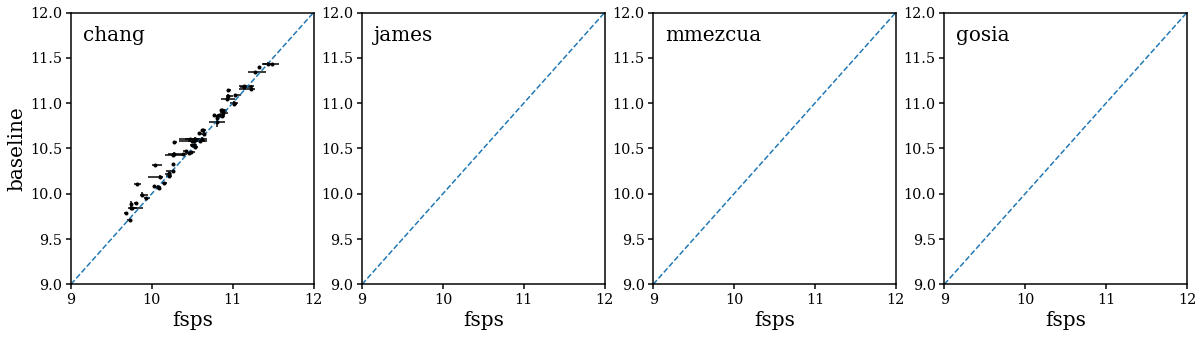

In [28]:
itheta = 0 # theta index

fig = plt.figure(figsize=(5*len(users), 5))
for i_user in range(len(users)): 
    sub = fig.add_subplot(1,len(users),i_user+1)
    sub.errorbar(fsps_chains[i_user,:,1,itheta], base_chains[i_user,:,1,itheta], 
                 xerr=[fsps_chains[i_user,:,1,itheta] - fsps_chains[i_user,:,0,itheta], fsps_chains[i_user,:,2,itheta] - fsps_chains[i_user,:,1,itheta]], 
                 yerr=[base_chains[i_user,:,1,itheta] - base_chains[i_user,:,0,itheta], base_chains[i_user,:,2,itheta] - base_chains[i_user,:,1,itheta]], fmt='.k')
    sub.plot([9., 12.], [9., 12.], c='C0', ls='--')
    sub.text(0.05, 0.95, users[i_user], ha='left', va='top', transform=sub.transAxes, fontsize=20)
    sub.set_xlabel('fsps', fontsize=20)
    sub.set_xlim(9., 12.)
    if i_user == 0: sub.set_ylabel('baseline', fontsize=20)
    sub.set_ylim(9., 12.)

Interestingly the $M_*$ constraints have a significant bias for the baseline model... This might mean that the offset we saw at low $M_*$ with the true $M_*$ may be caused by a bias in `speculator`. **Lets compare the inferred $M_*$ to the input/true $M_*$**: 

In [30]:
specs, meta = Data.Spectra(sim='lgal', noise='bgs0', lib='bc03', sample='mini_mocha')

In [33]:
ms_input = meta['logM_total'][:ngal]

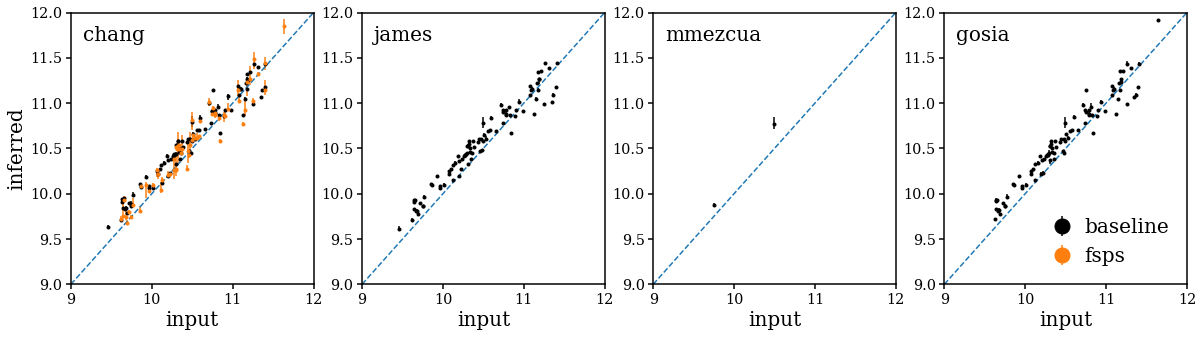

In [38]:
itheta = 0 # theta index

fig = plt.figure(figsize=(5*len(users), 5))
for i_user in range(len(users)): 
    sub = fig.add_subplot(1,len(users),i_user+1)
    _plt_base = sub.errorbar(ms_input, base_chains[i_user,:,1,itheta], 
                 yerr=[base_chains[i_user,:,1,itheta] - base_chains[i_user,:,0,itheta], base_chains[i_user,:,2,itheta] - base_chains[i_user,:,1,itheta]], fmt='.k')
    _plt_fsps = sub.errorbar(ms_input, fsps_chains[i_user,:,1,itheta],
                 yerr=[fsps_chains[i_user,:,1,itheta] - fsps_chains[i_user,:,0,itheta], fsps_chains[i_user,:,2,itheta] - fsps_chains[i_user,:,1,itheta]], fmt='.C1')
    sub.plot([9., 12.], [9., 12.], c='C0', ls='--')
    sub.text(0.05, 0.95, users[i_user], ha='left', va='top', transform=sub.transAxes, fontsize=20)
    sub.set_xlabel('input', fontsize=20)
    sub.set_xlim(9., 12.)
    if i_user == 0: sub.set_ylabel('inferred', fontsize=20)
    sub.set_ylim(9., 12.)
    if i_user == 3: sub.legend([_plt_base, _plt_fsps], ['baseline', 'fsps'], loc='lower right', handletextpad=0.1, markerscale=5, fontsize=20)